TODO:

- [ ] implement ring-all-reduce (and check it works)
- [ ] 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np

import itertools
from time import sleep, time
import toolz
import numpy as np

In [2]:
import distributed
distributed.__file__

'/Users/ssievert/Developer/dask/distributed/distributed/__init__.py'

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def get_model(model=None):
    if model is None:
        return Net()
    return getattr(torchvision.models, model)()

resnet_models = [m for m in dir(torchvision.models)
                 if 'resnet' in m and m != 'resnet']
models = [get_model(model=model) for model in resnet_models]

In [4]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
from distributed import Client
import distributed as d
client = Client()
client

<Client: scheduler='tcp://127.0.0.1:55362' processes=8 cores=8>

In [6]:
# num_workers = 4
# model = get_model()
model = Net()
iters = 20

# Centralized implementation

In [7]:
from time import sleep

In [8]:
def train(model, device, data, target):
    model.train()
    
    data, target = data.to(device), target.to(device)
    # optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # optimizer.step()
    return model

In [9]:
%load_ext autoreload
%autoreload 2

In [17]:
import copy
def clone(model):
    return copy.deepcopy(model)
class PS:
    model = None
    steps = -1
    
    def __init__(self, model, args, device, num_workers=1):
        model = model.to(device)
        self.model = model  # public -- always fresh
        self._model = clone(model)  # private -- to be updated, then copied to self.model
        self._grads_recvd = 0
        self.steps = 0
        
        self._grads = {}
        self.optimizer = optim.SGD(self._model.parameters(), lr=args.lr, momentum=args.momentum)
        self.num_workers = num_workers
        
    def push(self, key, grads):
        """
        For a worker to push some gradients to this PS
        """
        if key == self.steps:
            self._grads_recvd += 1
            self.aggregate(grads)
        
        # have we collected enough gradients?
        if self._grads_recvd == self.num_workers:
            self.take_step()
            self._grads_recvd = 0
            self.model = clone(self._model)
    
    def aggregate(self, grads):
        for name, param in self._model.named_parameters():
            if param.grad is None:
                param.grad = 0 * param
            param.grad += grads[name]
            
    def take_step(self):
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.steps += 1

In [18]:
def worker(ps, device, train_loader,
           worker_id=0, num_workers=1,
           iters=10):
    times = {'comm_grad': 0, 'compute_grad': 0, 'comm_model': 0}
    whole_start = time()
    
    step = -1
    while True:
        start = time()
        next_step = ps.steps
        times['check_time'] = time() - start
#         print(next_step)
        if next_step != step:
            start = time()
            step = next_step
            model = ps.model
            times['comm_model'] += time() - start
            
        if step > iters:
            break
            
        param_check = toolz.last(model.parameters())
        check = param_check.detach().numpy().flat[:4]
        print("iter {} worker {}, last params = {}".format(step, worker_id, check))
            
        data, target = next(iter(train_loader))
        start = time()
        model = train(model, device, data, target)
        grads = {name: p.grad.data for name, p in model.named_parameters()}
        times['compute_grad'] += time() - start
        
        start = time()
        ps.push(step, grads)
        times['comm_grad'] += time() - start
        
    params = [np.prod(tuple(p.size())) for p in model.parameters()]
    meta = {'compute_grad': times['compute_grad'] / iters,
            'comm_model': times['comm_model'] / iters,
            'comm_grad': times['comm_grad'] / iters,
            'check_time': times['check_time'] / iters,
            'avg_step_time': (time() - whole_start) / iters,
            'iters': iters,
            'num_workers': num_workers,
            'params': sum(params),
            'worker_id': worker_id}
    return meta

In [19]:
def train_centralized(client, model, args, num_workers, iters, batch_size=64):
    batch_size //= num_workers
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, model = client.scatter([train_loader, model])

    ps = client.gather(client.submit(PS, model, args, device,
                                     num_workers=num_workers,
                                     actor=True))
    futures = [client.submit(worker, ps, device, train_loader,
                             iters=iters,
                             worker_id=i, num_workers=num_workers)
               for i in range(num_workers)]
    meta = client.gather(futures)
    meta = [{'batch_size': batch_size, **m} for m in meta]
    return meta

In [20]:
meta = [train_centralized(client, model, args, num_workers, iters)
        for num_workers in [4]]

In [21]:
meta = [{'arch': 'centralized', **mi} for m in meta for mi in m]

In [15]:
all_meta = []

In [16]:
all_meta += meta

In [17]:
import pandas as pd
df = pd.DataFrame(all_meta)
df.head()

arch  avg_step_time  batch_size  check_time  comm_grad  comm_model  \
0  centralized       0.093037          32    0.000252   0.000649    0.009771   
1  centralized       0.083597          32    0.000642   0.000296    0.009929   
2  centralized       0.038076          16    0.000407   0.000184    0.006811   
3  centralized       0.097283          16    0.000950   0.000367    0.012390   
4  centralized       0.105316          16    0.000302   0.000411    0.012041   

   compute_grad  iters  num_workers  params  worker_id  
0      0.040861     20            2   21840          0  
1      0.034777     20            2   21840          1  
2      0.015234     20            4   21840          0  
3      0.041610     20            4   21840          1  
4      0.037431     20            4   21840          2

Here's calling the train function. This can be called repeated times, since the function `worker` gets the latest model to start.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

keep = df.drop(columns=['params', 'batch_size', 'iters', 'avg_step_time'])
melted = keep.melt(id_vars=['arch', 'num_workers', 'worker_id'],
                   value_name='time (s)')
melted.head()

arch  num_workers  worker_id    variable  time (s)
0  centralized            2          0  check_time  0.000208
1  centralized            2          1  check_time  0.000296
2  centralized            4          0  check_time  0.000297
3  centralized            4          1  check_time  0.000315
4  centralized            4          2  check_time  0.000575

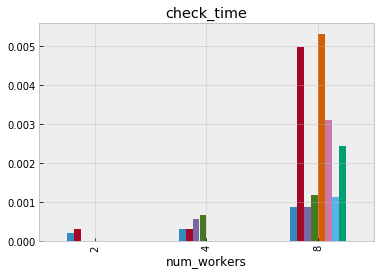

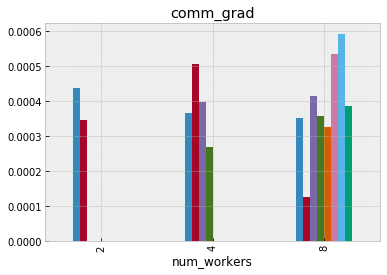

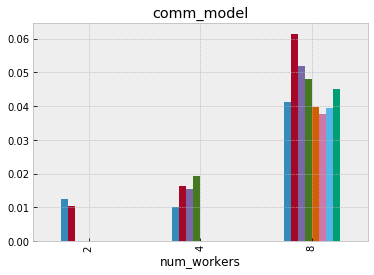

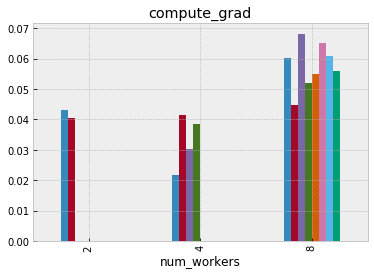

In [19]:
for var in melted.variable.unique():
    show = melted[melted.variable == var]
    show = show.pivot_table(columns='worker_id', values='time (s)',
                     index='num_workers', aggfunc=np.mean)
    show.plot.bar(logy=False, legend=False, title=var)

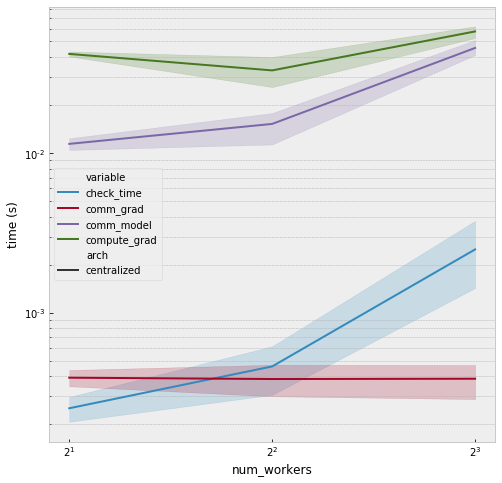

In [22]:
w = 8
fig, ax = plt.subplots(figsize=(w, w))
sns.lineplot(x='num_workers', y='time (s)',
             hue='variable', style='arch', data=melted)
ax.set_yscale("log")
ax.set_xscale("log", basex=2)
ax.grid(which='both')
plt.savefig('centralized.png', dpi=300)